Buidling MakeMore MLP

In [124]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
#Loading our data
words = open(r'dataset\names.txt',mode='r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [8]:
#charset
chars = sorted(list(set(''.join(words))))
S_to_I = {s:i+1 for i,s in enumerate(chars)}
S_to_I['.'] = 0
I_to_S = {i:s for s,i in S_to_I.items()}

print(I_to_S)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


Building the Dataset, and context size (length) and storing our input/index char (X) & our probable/next char (Y) in tensors.

In [78]:
block_size = 3
X, Y = [],[]
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w +'.':
        ix = S_to_I[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(I_to_S[i] for i in context), '----->', I_to_S[ix])
        context = context[1:] + [ix]
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [144]:
def build_dataset(words):
    block_size = 3
    X, Y = [],[]
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w +'.':
            ix = S_to_I[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(I_to_S[i] for i in context), '----->', I_to_S[ix])
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 *len(words))
n2 = int(0.9*len(words))

X_train, y_train = build_dataset(words[n1:])
X_valid, y_valid = build_dataset(words[n1:n2])
X_test , y_test = build_dataset(words[n2:])

In [146]:
len(X_train), len(X_test), len(X_valid)

(45521, 22866, 22655)

In [147]:
len(y_train), len(y_test), len(y_valid)

(45521, 22866, 22655)

Implementing our lookup & Embedding table (lookup C, init to randn) ----------

In [20]:
C = torch.randn([27,2])

F.one_hot(torch.tensor(3), num_classes=27).float()
Another way to index in our lookup table using F.one_hot, which stretches out the input tensor and switches only the index at 3, when applying matrix mult. (1,27) @ (27,2) = (1,2) tensor which is == indexing in the lookup table.

In [33]:
emb = C[X]
emb.shape

torch.Size([16, 3, 2])

Bulilding the hidden layer (tanh activation with 100 nodes as output from it)

In [34]:
w1 = torch.randn([6,100]) #created weights1 init to randn tensor with shape (3*2 from our embedding, and 100 outputs as per our hyperparameter)
b1 = torch.randn((100))

N.B Always check if tensors are broadcastable, in this case because we are adding b1 to the product of emb.view() & w1. We need to check that the product & b1 are broadcastable

In [ ]:
#Tensor Sizes
# PRODUCT - (   N  , 100)
# BIAS    - (  '1' , 100)

They are broadcastable

In [41]:
#x*w + b
h = torch.tanh((emb.view([-1,6]) @ w1) + b1)
h

tensor([[ 0.9894, -0.9458, -0.8773,  ...,  0.9513,  0.8980,  0.9938],
        [ 0.9994, -0.9187, -0.9495,  ...,  0.9393,  0.9033,  0.8727],
        [-0.9878, -0.9980, -0.9133,  ...,  0.9929,  0.9694,  0.9999],
        ...,
        [-0.6835, -0.6954,  0.2377,  ...,  0.9978,  0.9603,  0.9505],
        [ 0.9970,  0.3505, -0.9602,  ...,  0.9132, -0.9787,  0.9951],
        [-0.8687,  0.9921,  0.2299,  ...,  0.9960, -0.8874, -0.9947]])

Creating the softmax layer, outputting probability of our possible charset

In [44]:
w2 = torch.randn([100,27]) #created weights2 init to randn tensor with shape (100 as outputs from prev layer tanh, and 27 outputs as per our 'possible' charset)
b2 = torch.randn((27))

logits = h @ w2 +b2
logits.shape

torch.Size([16, 27])

Creating loss function (Mean Log Likelihood)

In [54]:
counts = logits.exp()
prob = counts / counts.sum(dim=1, keepdim=True)

loss = -prob[torch.arange(16),Y].log().mean()
loss

tensor(13.6191)

Optimization Again!!!

In [170]:
g =  torch.Generator().manual_seed(2147483647)
C = torch.randn([27,10], generator=g)
w1 = torch.randn([30,300]) #created weights1 init to randn tensor with shape (3*2 from our embedding, and 100 outputs as per our hyperparameter)
b1 = torch.randn((300))
w2 = torch.randn([300,27]) #created weights2 init to randn tensor with shape (100 as outputs from prev layer tanh, and 27 outputs as per our 'possible' charset)
b2 = torch.randn((27))
params = [C, w1, b1, w2, b2] #created new params variable to hold all Parameters as a list, so we can calculate total parameters in our network

In [172]:
print(sum(p.nelement() for p in params))
for p in params:
    p.requires_grad = True

17697


In [135]:
learn_exp = torch.linspace(-3, 0,steps=1000)
learn_step = 10**learn_exp

In [173]:
learn_used = []
steps = []
loss_acq = []

In [190]:
for i in range(100000):
    #Minibatch from dataset
    batch_size = torch.randint(0, X_train.shape[0], (64,))
    
    #Forward pass
    emb = C[X_train[batch_size]]
    h = torch.tanh((emb.view([-1,30]) @ w1) + b1)
    logits = h @ w2 +b2
    #counts = logits.exp()
    #prob = counts / counts.sum(dim=1, keepdim=True)
    #loss = -prob[torch.arange(16),Y].log().mean()
    loss = F.cross_entropy(logits, y_train[batch_size])
    
    #Backward pass
    for p in params:
        p.grad =None
    loss.backward()
    #learning rate adjust
    #lr = learn_step[i]
    #Update
    lr= 0.1 if i < 50000 else 0.01
    for p in params:
        p.data += -lr * p.grad
    #learning rate tracking
    #learn_used.append(learn_exp[i])
    steps.append(i)
    loss_acq.append(loss.log10().item())
        
print(loss.item())

1.8739458322525024


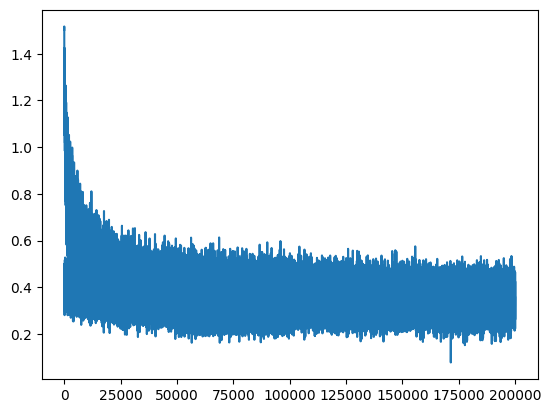

In [191]:
plt.plot(steps,loss_acq)

Loss on entire Training set (no batches)

In [192]:
emb = C[X_train]
h = torch.tanh((emb.view([-1,30]) @ w1) + b1)
logits = h @ w2 +b2
#counts = logits.exp()
#prob = counts / counts.sum(dim=1, keepdim=True)
#loss = -prob[torch.arange(16),Y].log().mean()
loss = F.cross_entropy(logits, y_train)
print(loss.item())


2.0213379859924316


Loss on Validation set

In [193]:
emb = C[X_valid]
h = torch.tanh((emb.view([-1,30]) @ w1) + b1)
logits = h @ w2 +b2
#counts = logits.exp()
#prob = counts / counts.sum(dim=1, keepdim=True)
#loss = -prob[torch.arange(16),Y].log().mean()
loss = F.cross_entropy(logits, y_valid)
print(loss.item())


2.0201516151428223


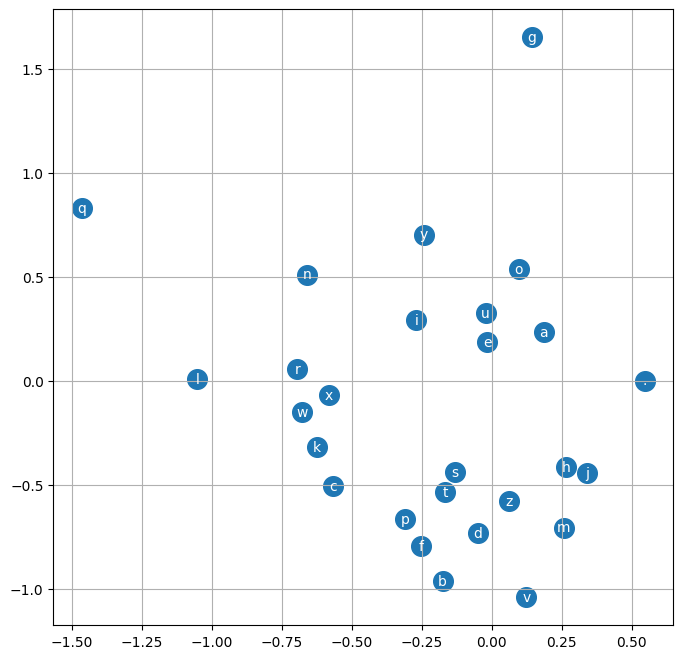

In [169]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data, s=200)
for i in range (C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), I_to_S[i], ha= 'center', va= 'center', color='white')
    plt.grid('minor')

Sampling from the model

In [194]:
g = torch.Generator().manual_seed(2147483647)


for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh((emb.view(1,-1) @ w1) + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
        
    print(''.join(I_to_S[i] for i in out))

junide.
jaya.
azha.
cory.
alin.
korin.
toria.
saree.
kalania.
yani.
eveav.
dedaine.
ambrissayiely.
arth.
faveum.
kyfiette.
maryas.
mah.
jaylie.
raaysen.
